In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import mysql.connector
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from IPython import display 
from models import *

Se realiza la carga de los datos desde una DB remota a un Data Frame de Pandas para realizar un tratamiento inicial (Label Encoding para el target)

In [2]:
conn = mysql.connector.connect(user='ml_client', password='distsys_2023@',
                              host='129.159.106.139',
                              database='ml_project')

db_cursor = conn.cursor()

db_cursor.execute('SELECT * FROM `TABLE 1`')

table_rows = db_cursor.fetchall()

df = pd.DataFrame(table_rows)

In [3]:
# df = pd.read_csv('data/cancer_data.csv')
le = LabelEncoder()
df[1] = le.fit_transform(df[1])
df.head()

0   1           2           3            4             5          6    
0    842302   1  17.9900000  10.3800000  122.8000000  1001.0000000  0.1184000  \
1    842517   1  20.5700000  17.7700000  132.9000000  1326.0000000  0.0847400   
2  84300903   1  19.6900000  21.2500000  130.0000000  1203.0000000  0.1096000   
3  84348301   1  11.4200000  20.3800000   77.5800000   386.1000000  0.1425000   
4  84358402   1  20.2900000  14.3400000  135.1000000  1297.0000000  0.1003000   

          7          8          9   ...          22          23           24   
0  0.2776000  0.3001000  0.1471000  ...  25.3800000  17.3300000  184.6000000  \
1  0.0786400  0.0869000  0.0701700  ...  24.9900000  23.4100000  158.8000000   
2  0.1599000  0.1974000  0.1279000  ...  23.5700000  25.5300000  152.5000000   
3  0.2839000  0.2414000  0.1052000  ...  14.9100000  26.5000000   98.8700000   
4  0.1328000  0.1980000  0.1043000  ...  22.5400000  16.6700000  152.2000000   

             25         26         27         28         29         30   
0  2019.0000000  0.1622000  0.6656000  0.7119000  0.2654000  0.4601000  \
1  1956.0000000  0.1238000  0.1866000  0.2416000  0.1860000  0.2750000   
2  1709.0000000  0.1444000  0.4245000  0.4504000  0.2430000  0.3613000   
3   567.7000000  0.2098000  0.8663000  0.6869000  0.2575000  0.6638000   
4  1575.0000000  0.1374000  0.2050000  0.4000000  0.1625000  0.2364000   

          31  
0  0.1189000  
1  0.0890200  
2  0.0875800  
3  0.1730000  
4  0.0767800  

[5 rows x 32 columns]

In [4]:
y = df[1].values
df = df.drop(1, axis=1)
df = df.drop(0, axis=1)
df = df.dropna(axis=1)
X = df.values
(X.shape, y.shape)

((569, 30), (569,))

Se realiza un escalado de los parámetros en el rango de 0-1

In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Comenzamos con el procedimiento de selección de características. La estrategia es determinar cuales son las mejores características para utilizar en los métodos de clasificación evaluando la "usabilidad" que poseen. En este caso, ya que la distribución de las muestras es aproximadamente una normal, el enfoque se desarrollará alrededor de esa idea.

<ActiveRun: >

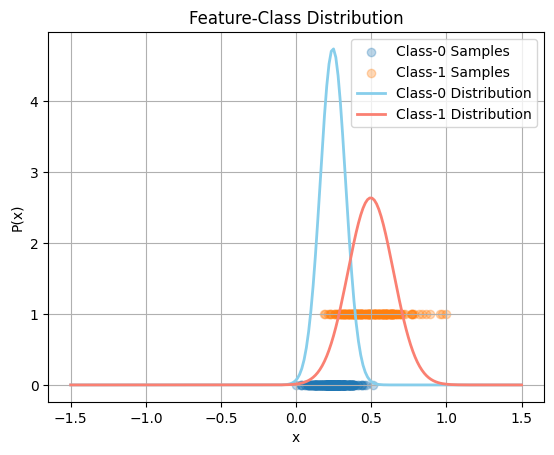

In [6]:
params = get_feature_distribution(X[:,0], y)

overlapping_error, mean_difference, fig = feature_performance(X[:,0], y,
                        params['mu0'],
                        params['std0'],
                        params['mu1'], 
                        params['std1'],
                        plot=True)
mlflow.create_experiment('Cancer_Detection', 'mlflow/experiments')
mlflow.set_experiment('Cancer_Detection')


mlflow.start_run(run_name='data_engineering')

    


Una vez que se obtienen los parámetros de las distribuciones a las que presuntamente pertenecen las muestras de cada clase (según la feature que se esté evaluando), se calcula la distancia que existe entre las medias y el grado de superposición que existe entre las distribuciones, que no es otra cosa que la suma del error alfa y beta en la mezcla de gaussianas.

In [7]:
overlapping_error, mean_difference

(67.72969457749745, 0.2516118310925949)

Esta idea nos permite visualizar y cuantificar el valor de cada feature en el conjunto de datos.

c:\Users\ChaarlyZ\OneDrive - CINVESTAV\Escritorio\Maestria\2do Cuatrimestre\Machine Learning\Project\data_tools.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


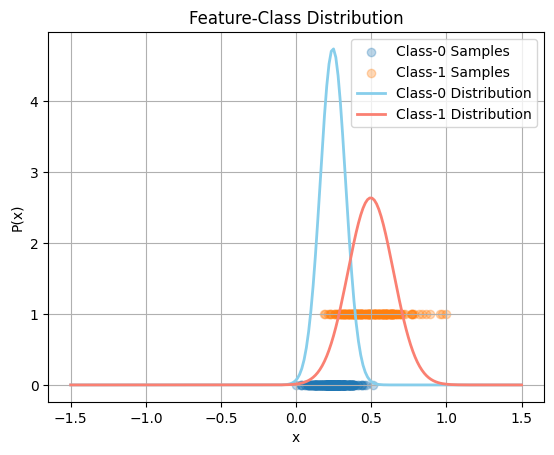

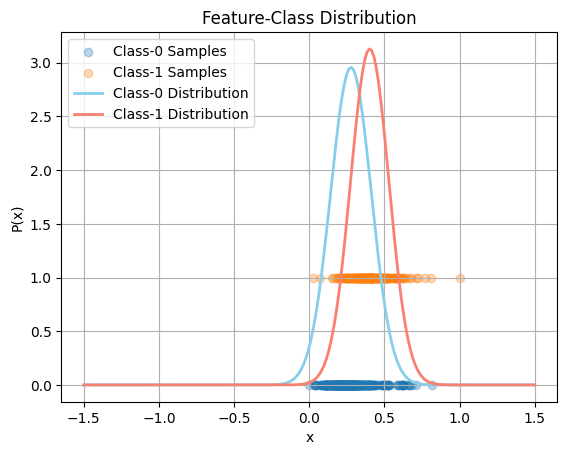

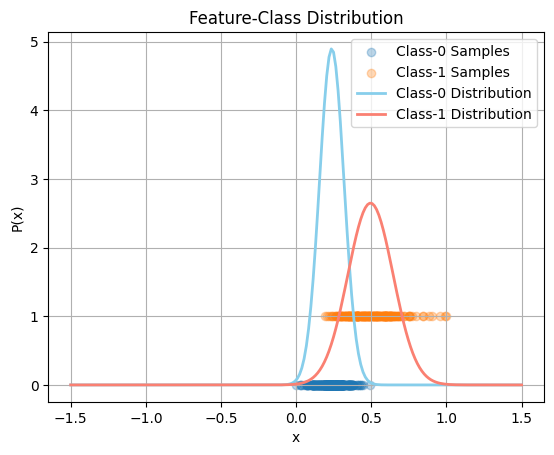

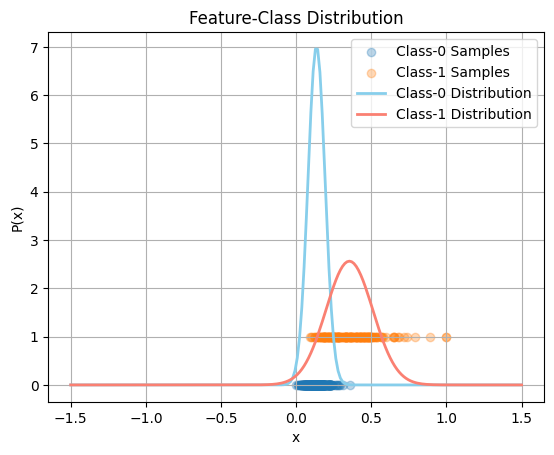

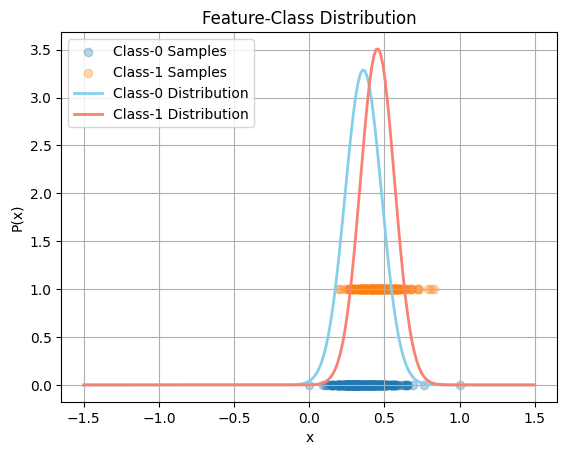

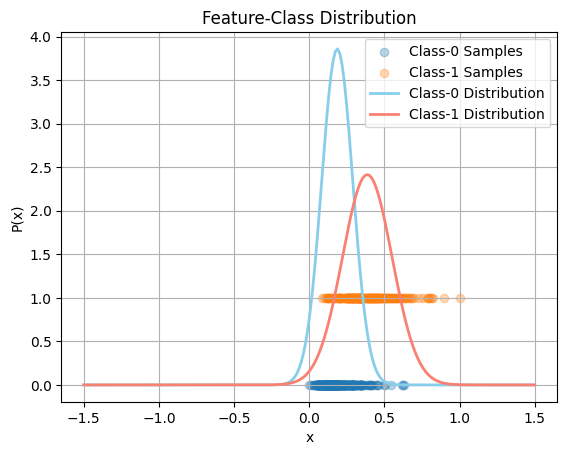

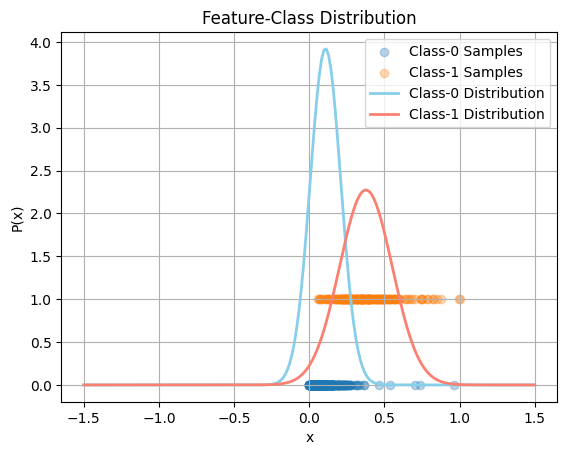

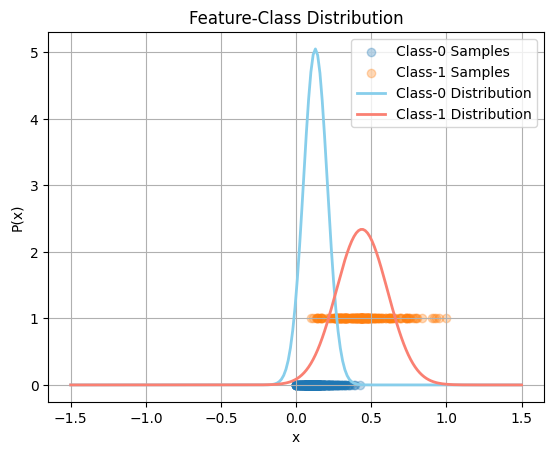

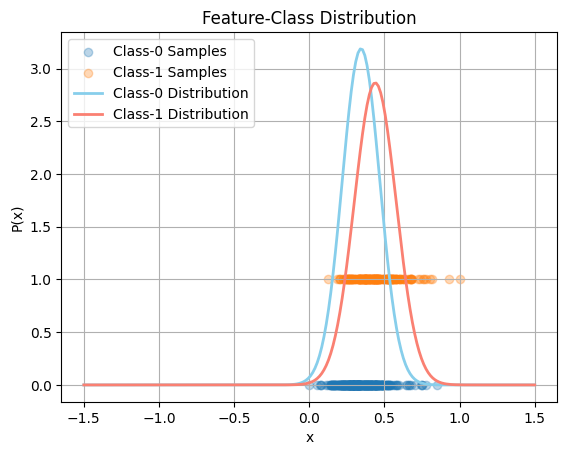

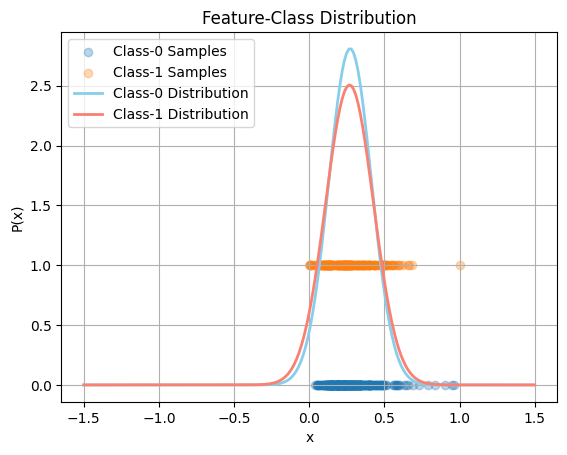

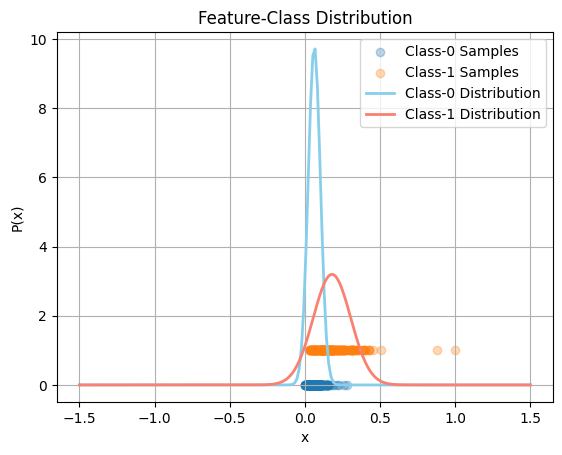

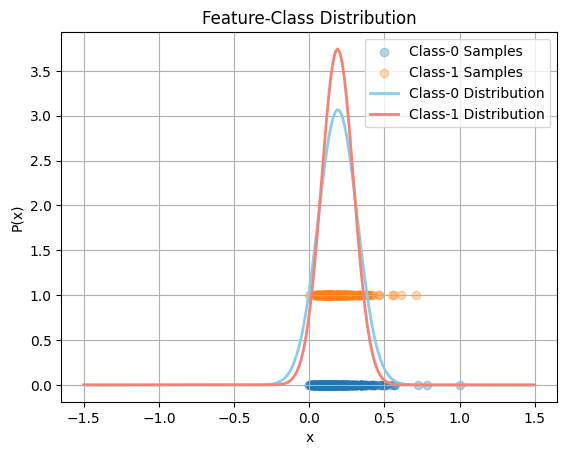

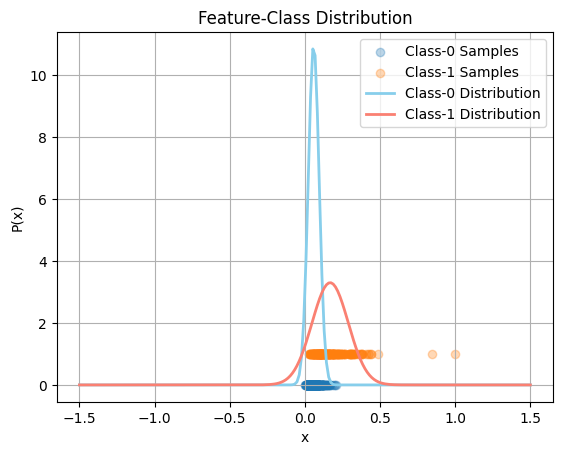

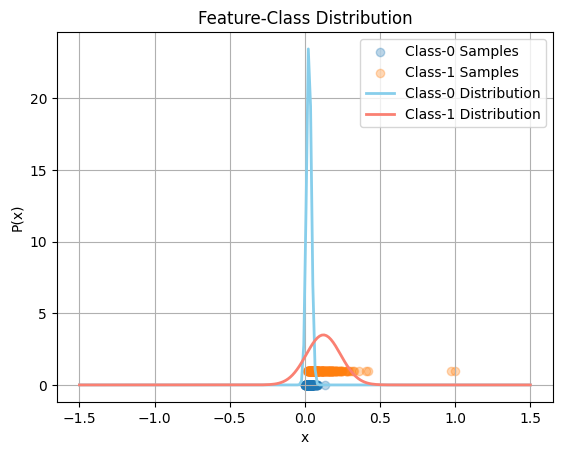

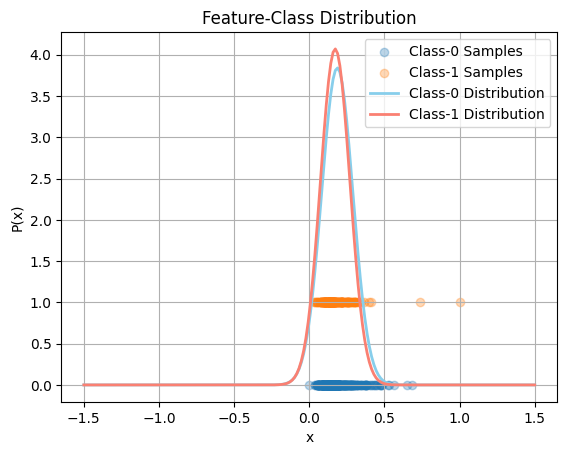

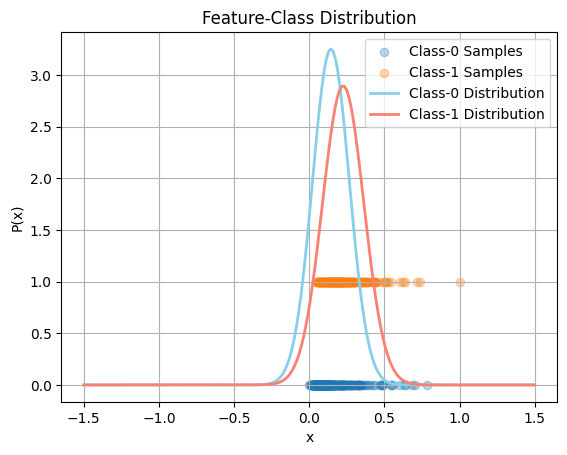

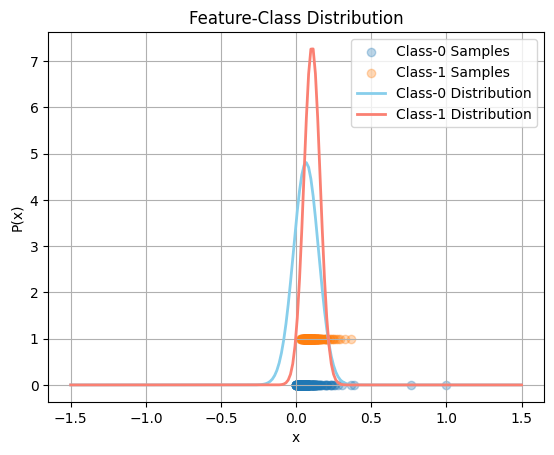

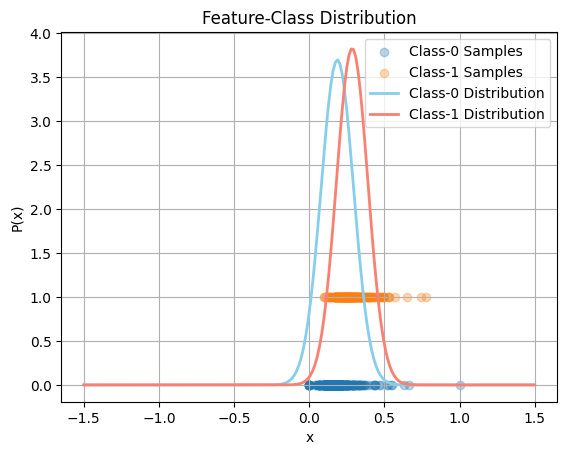

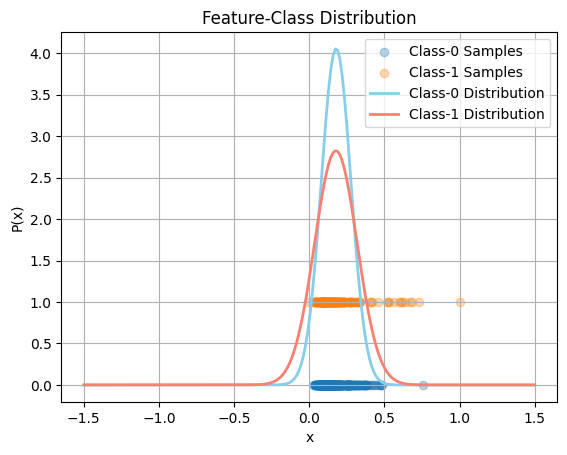

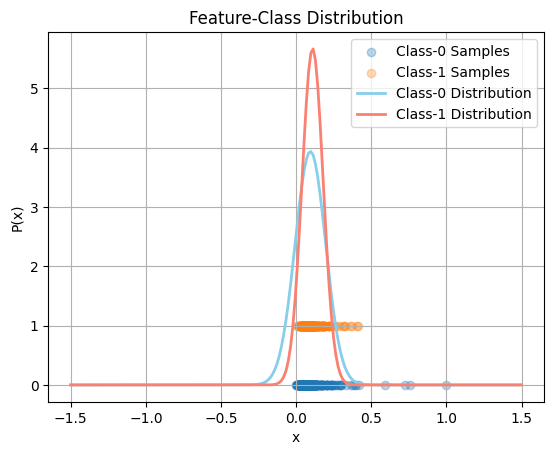

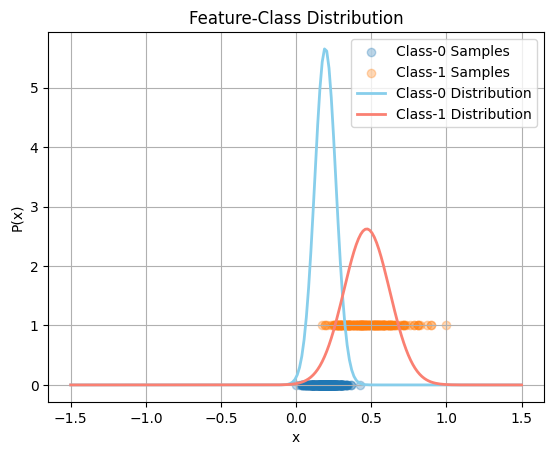

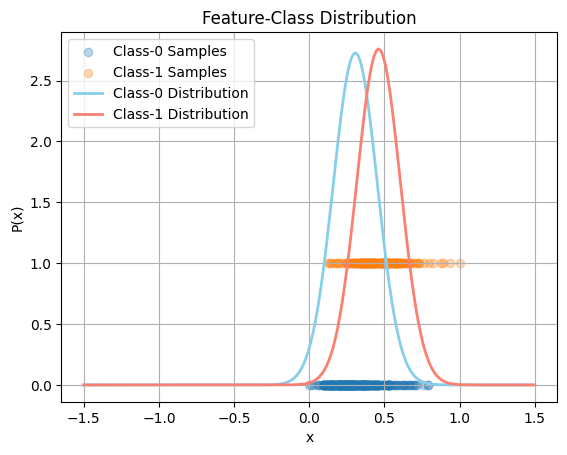

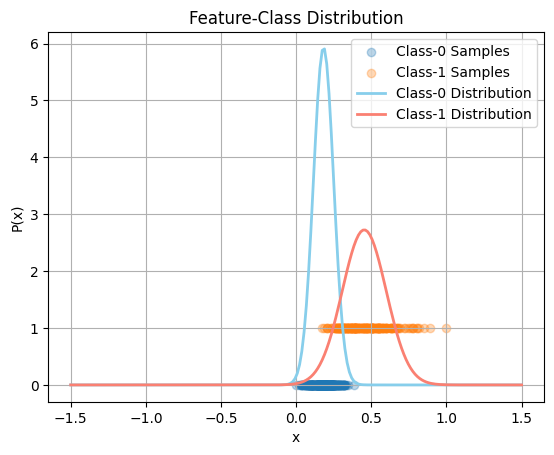

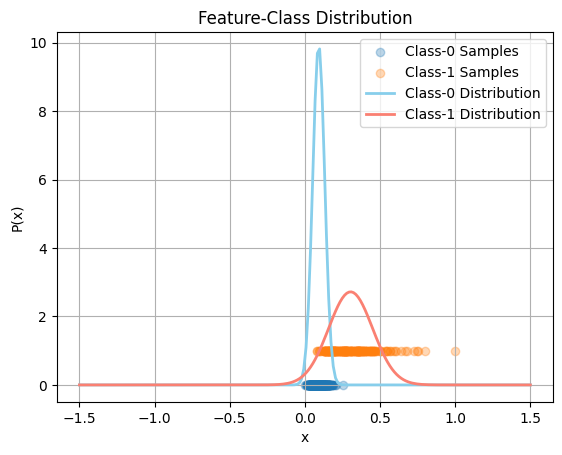

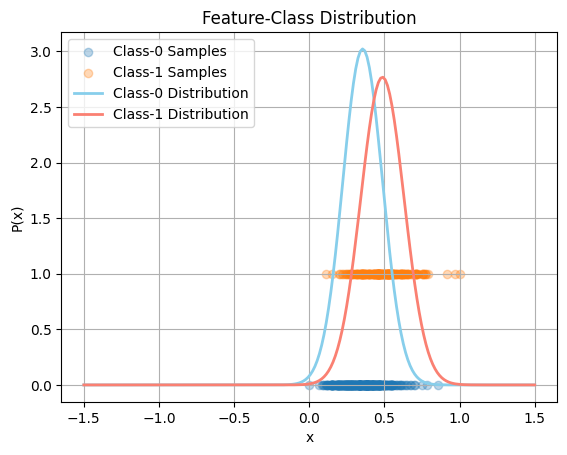

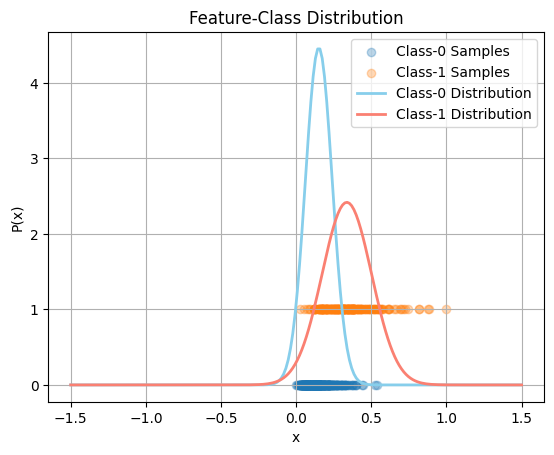

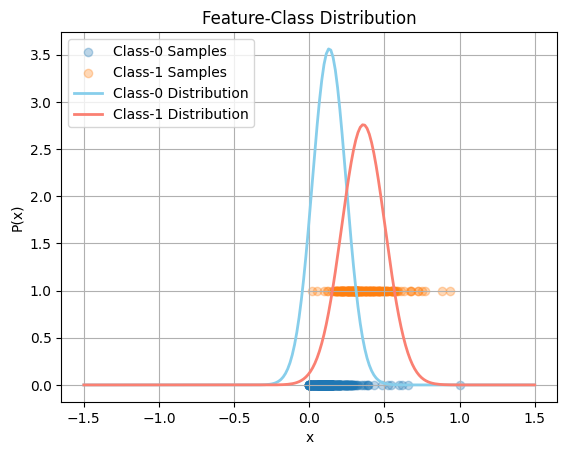

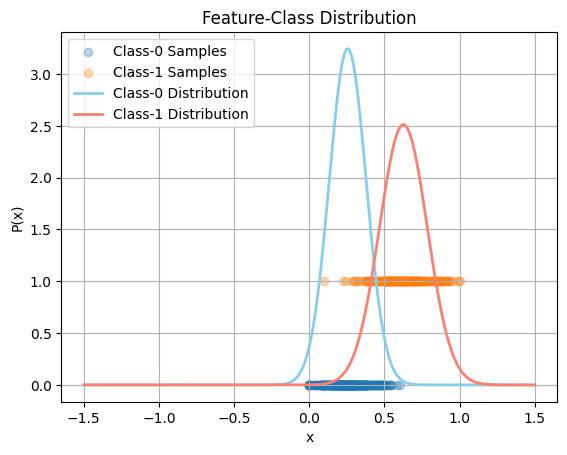

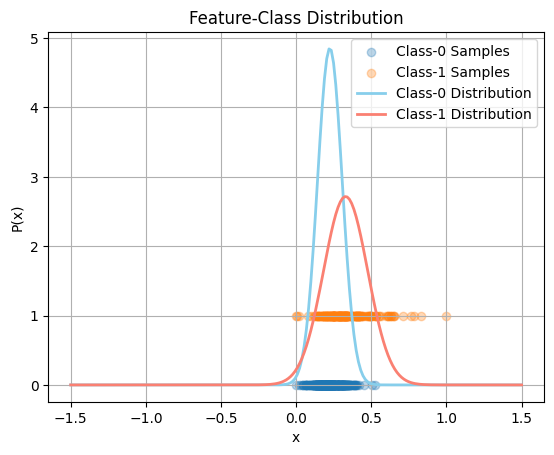

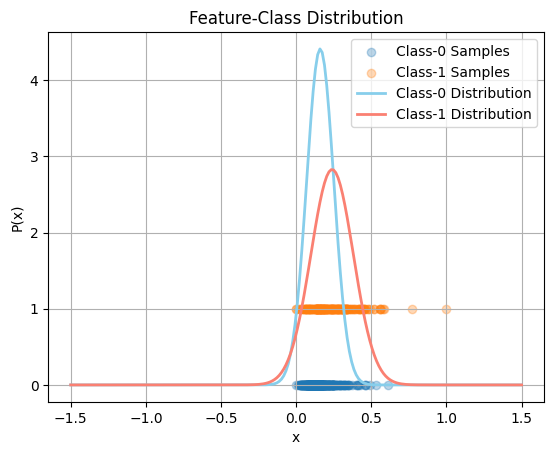

In [8]:
ovr_error = []
mean_diffs = []
x_filt = X
y_filt = y
outlier_limit = 3

def filter_outliers(x_filt, y_filt, p, outlier_limit=3):

    #Filtro de clases
    c0_filt0 = x_filt[y_filt==0]
    c1_filt0 = x_filt[y_filt==1]
    y0_0 = y_filt[y_filt==0]
    y1_0 = y_filt[y_filt==1]

    #Cota inferior
    c0_filt1 = c0_filt0[c0_filt0[:,i]>=(p['mu0'] - p['std0'] * outlier_limit)]
    c1_filt1 = c1_filt0[c1_filt0[:,i]>=(p['mu1'] - p['std1'] * outlier_limit)]
    y0_1 = y0_0[c0_filt0[:,i]>=(p['mu0'] - p['std0'] * outlier_limit)]
    y1_1 = y1_0[c1_filt0[:,i]>=(p['mu1'] - p['std1'] * outlier_limit)]

    #Cota superior
    c0_filt2 = c0_filt1[c0_filt1[:,i]<=(p['mu0'] + p['std0'] * outlier_limit)]
    c1_filt2 = c1_filt1[c1_filt1[:,i]<=(p['mu1'] + p['std1'] * outlier_limit)]

    y0_2 = y0_1[c0_filt1[:,i]<=(p['mu0'] + p['std0'] * outlier_limit)]
    y1_2 = y1_1[c1_filt1[:,i]<=(p['mu1'] + p['std1'] * outlier_limit)]

    # print(f'x: {c0_filt2.shape}; y: {y0_2.shape}')
    # print(f'x: {c1_filt2.shape}; y: {y1_2.shape}')

    x_filt = np.concatenate([c0_filt2, c1_filt2])
    y_filt = np.concatenate([y0_2, y1_2])
    # print(f'x: {x_filt.shape}; y: {y_filt.shape}')

    return x_filt, y_filt



for i in range(X.shape[1]):
    p = get_feature_distribution(X[:,i], y)
    o, m, fig = feature_performance(X[:,i], y,
                        p['mu0'],
                        p['std0'],
                        p['mu1'], 
                        p['std1'],
                        plot=True)
    mlflow.log_figure(fig, f'mlflow/figures/distributions/dirties/dirty_{i}.png')
    x_filt, y_filt = filter_outliers(x_filt, y_filt, p, 3)
    

    
    ovr_error.append(o)
    mean_diffs.append(m)  
    

Una vez que conocemos los parámetros de cada distribución, podemos aprovecharlos para deshacernos de los outliers parametrizando los filtros en función de la confianza que deseemos integrar en el dataset. En este caso, optaremos por un nivel de confianza del 99.7% y descartaremos cualquier muestra que se localice fuera de los límites: $$\mu \pm 3\times \sigma$$

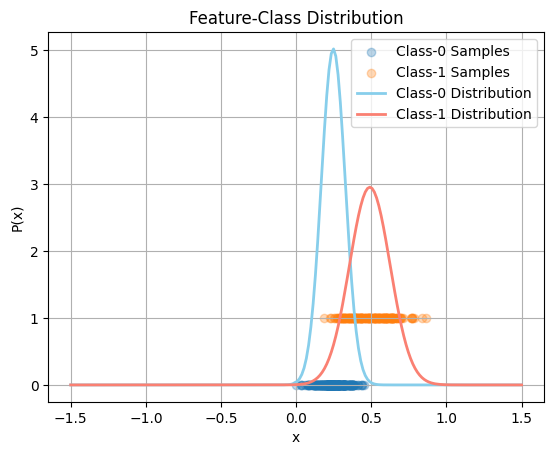

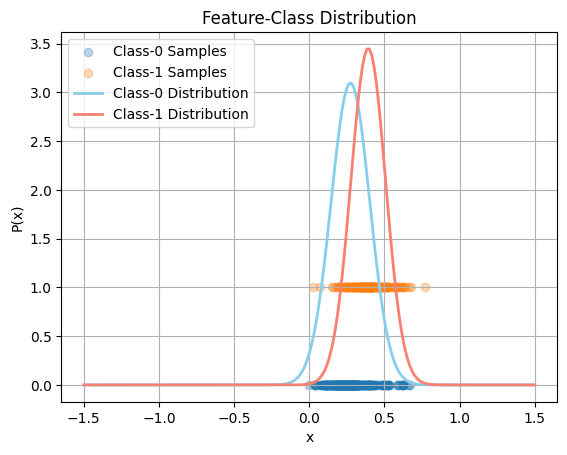

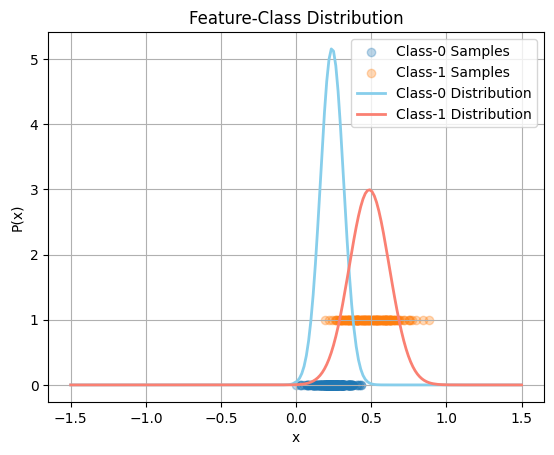

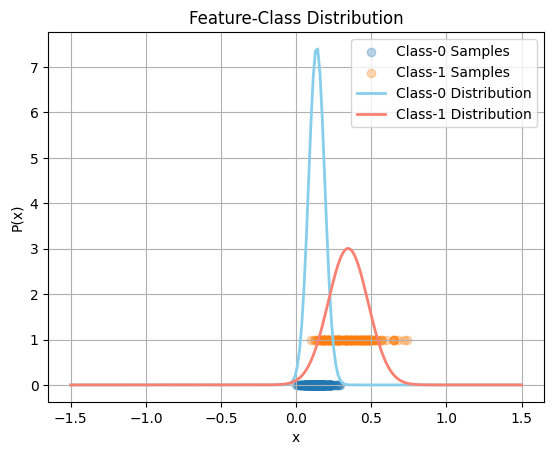

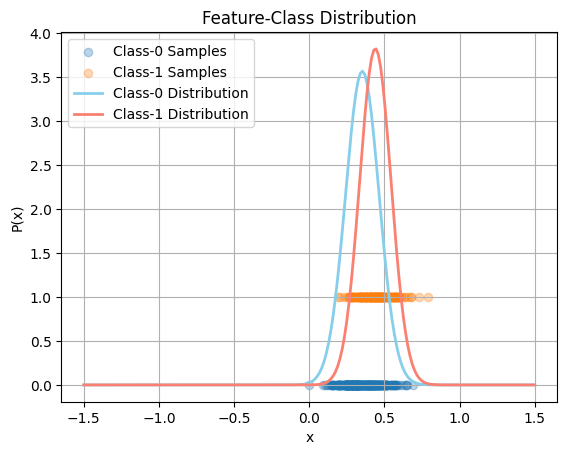

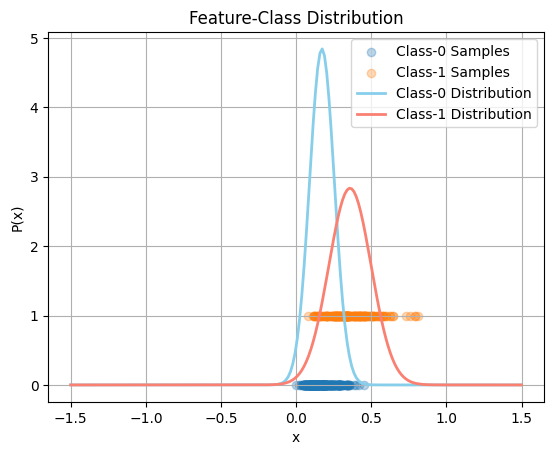

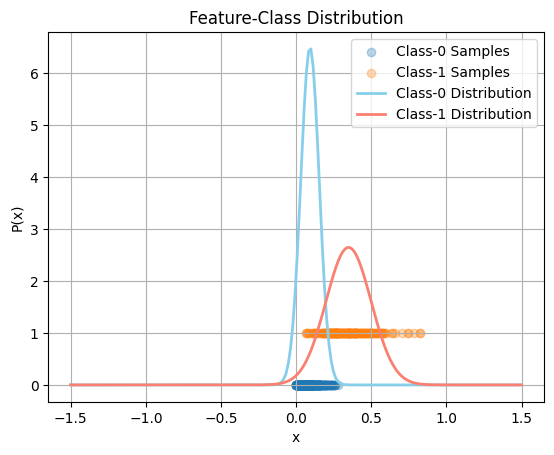

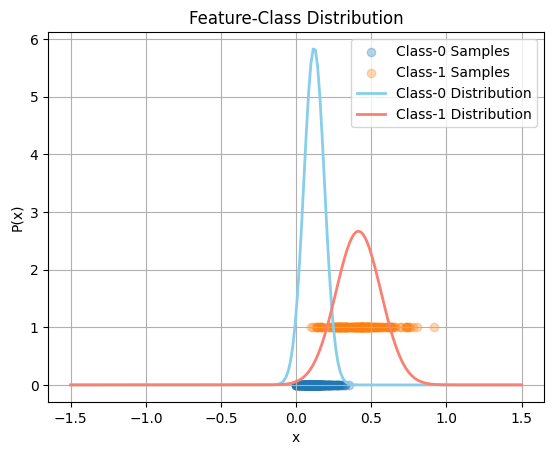

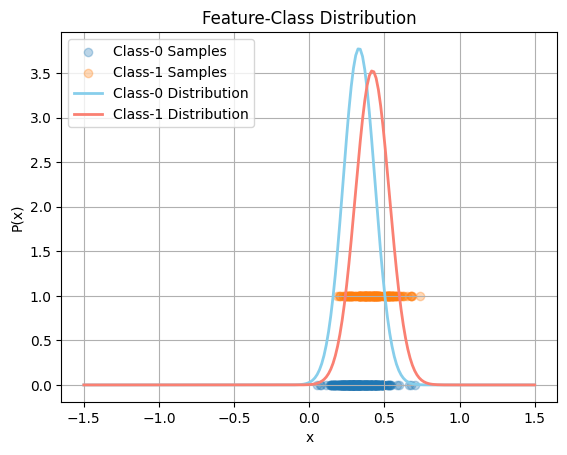

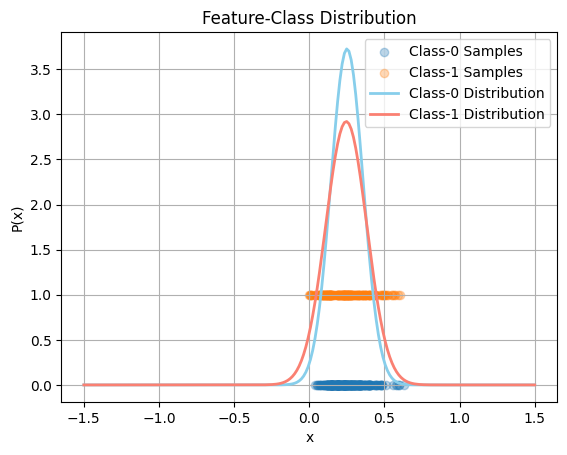

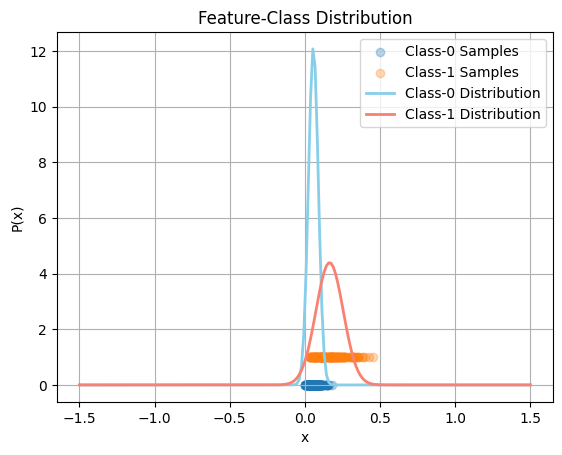

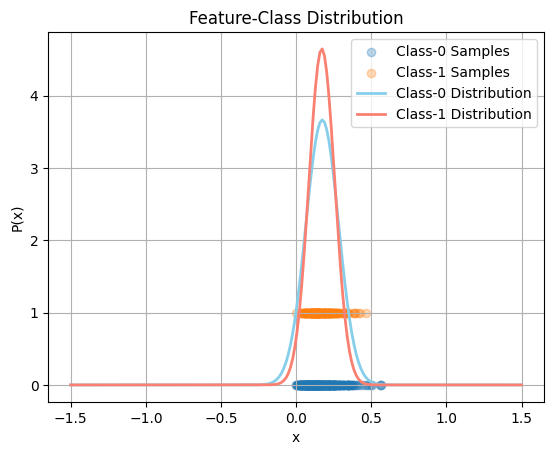

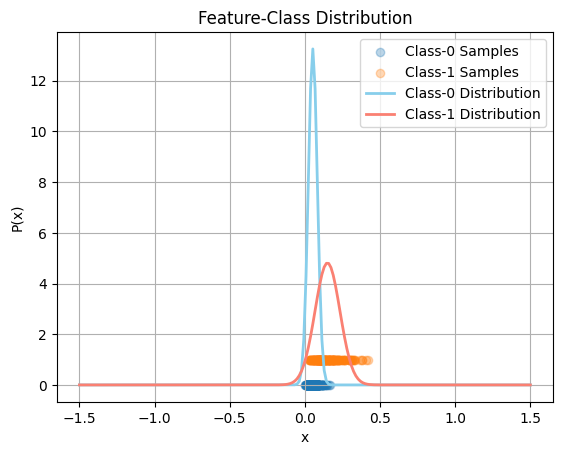

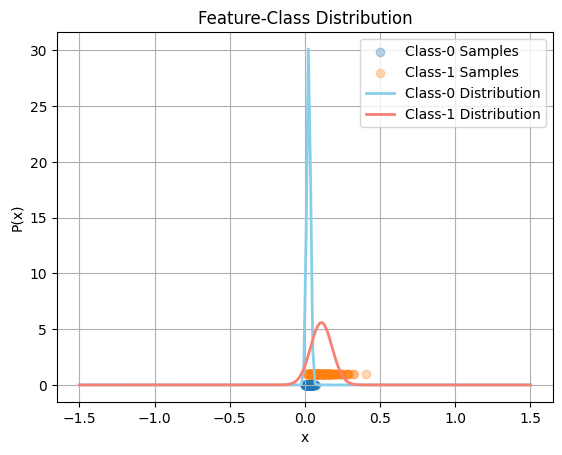

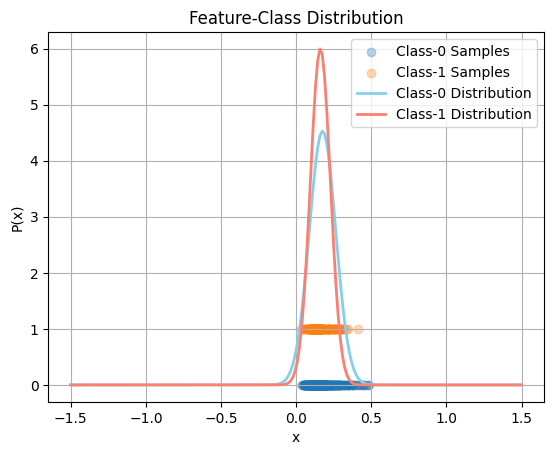

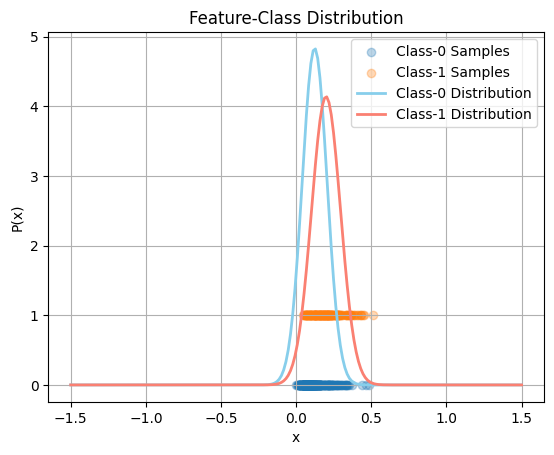

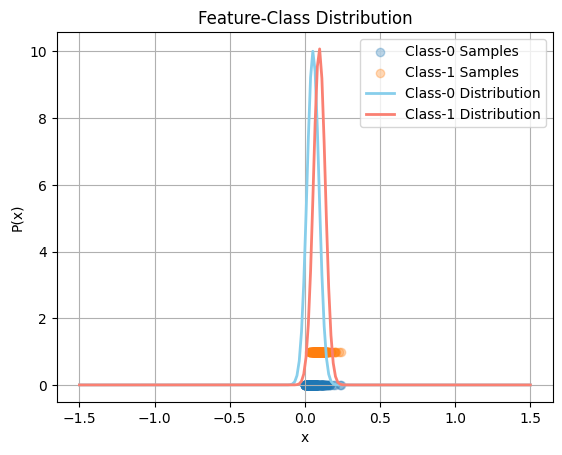

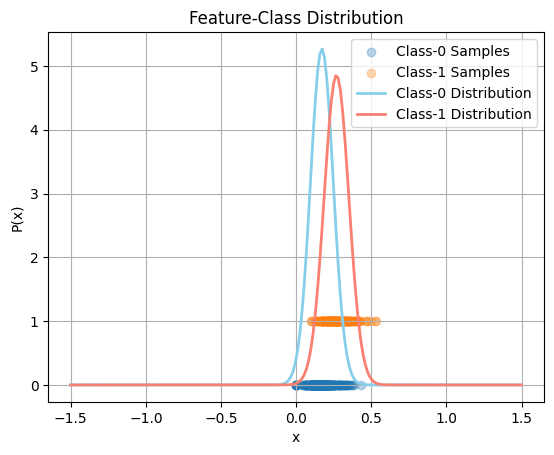

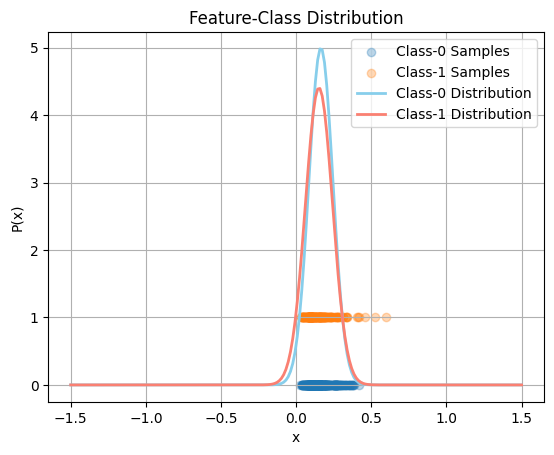

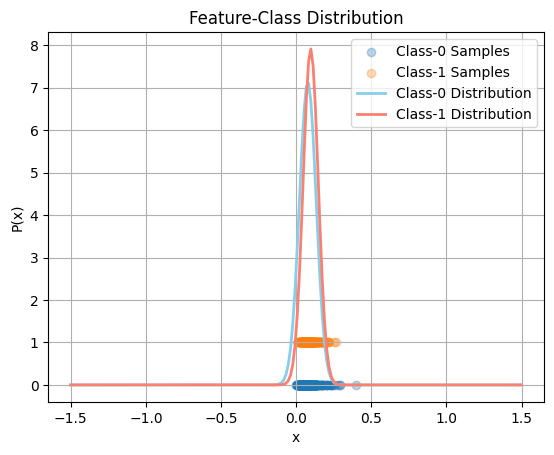

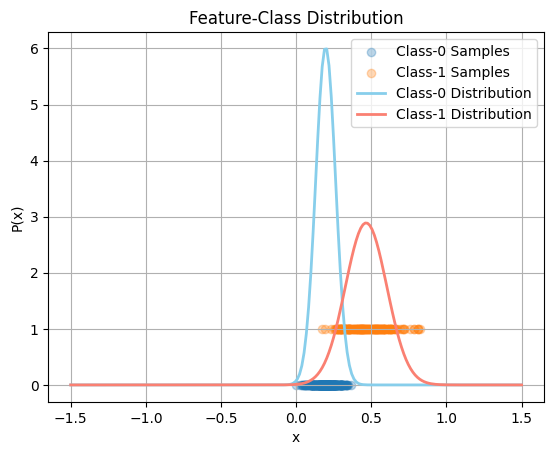

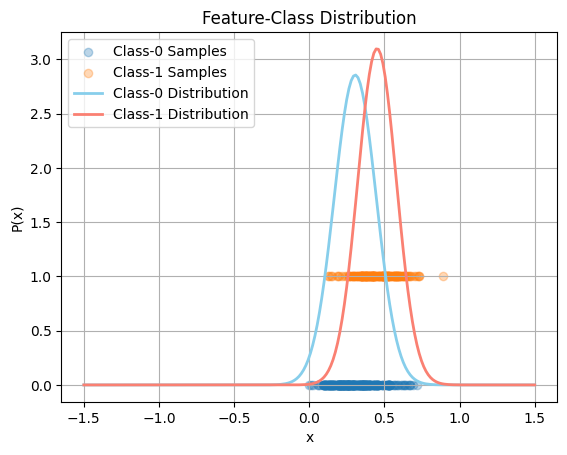

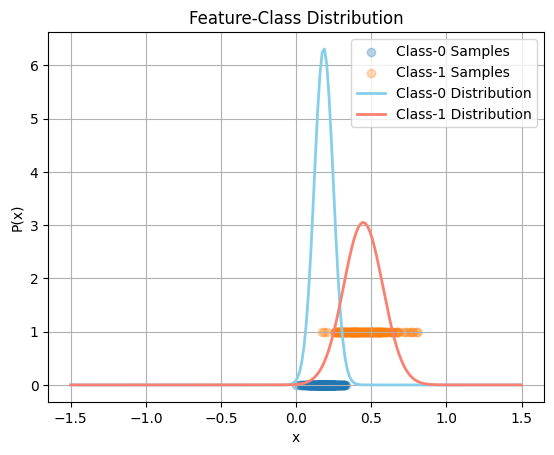

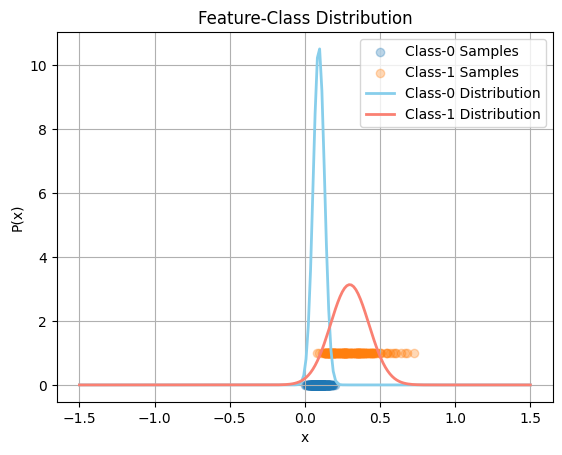

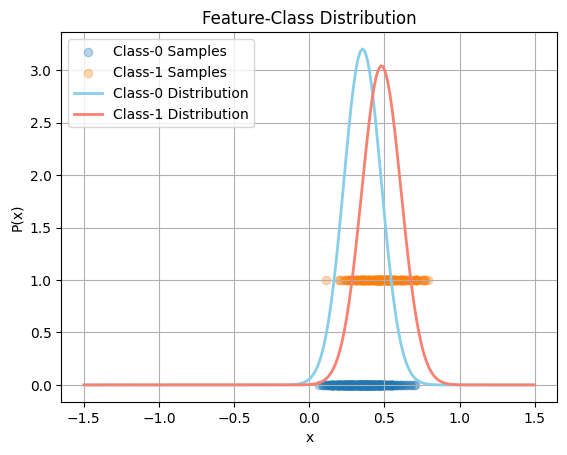

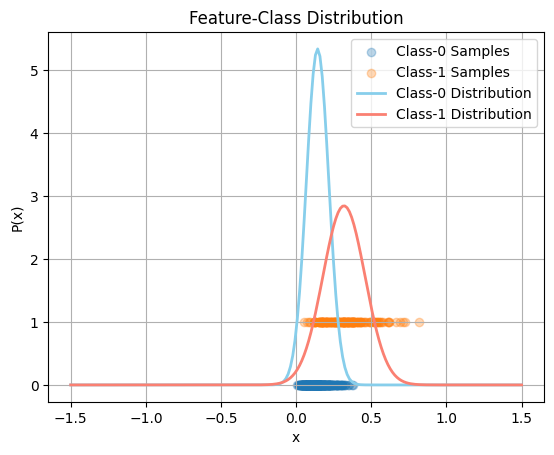

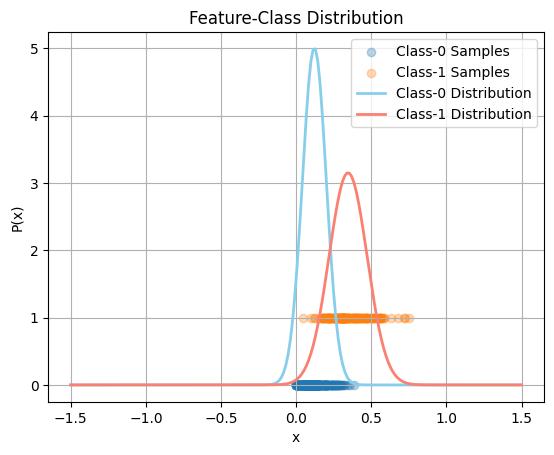

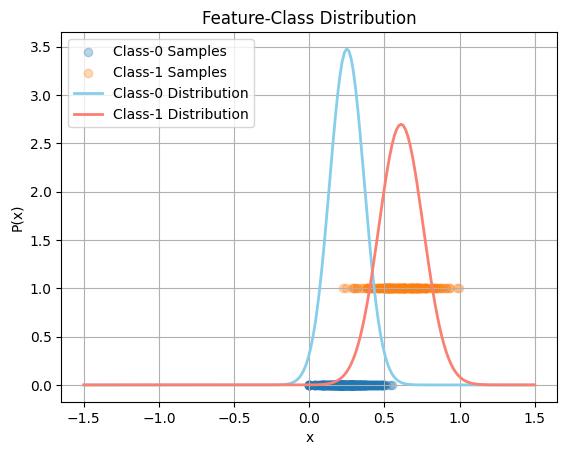

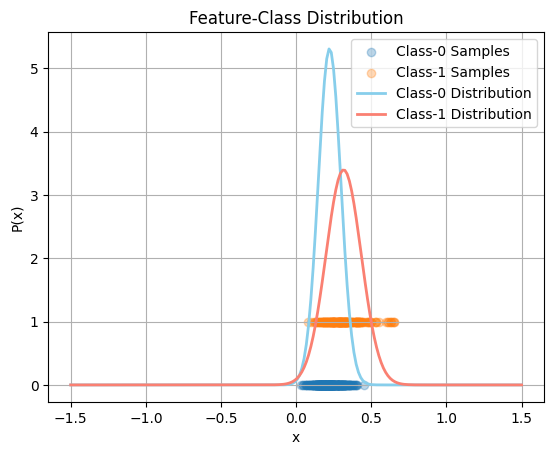

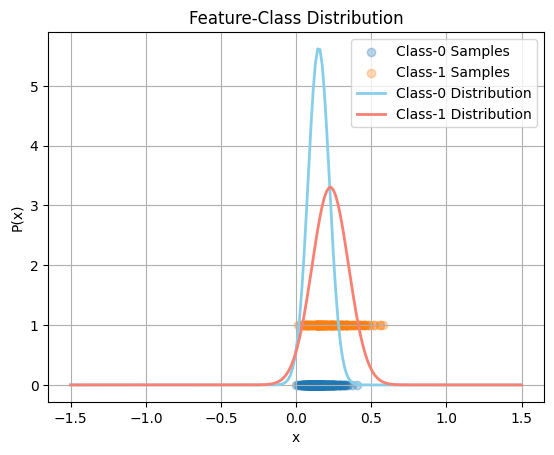

In [9]:
for i in range(x_filt.shape[1]):
    p = get_feature_distribution(x_filt[:,i], y_filt)
    o, m, fig = feature_performance(x_filt[:,i], y_filt,
                        p['mu0'],
                        p['std0'],
                        p['mu1'], 
                        p['std1'],
                        plot=True)
    mlflow.log_figure(fig, f'mlflow/figures/distributions/cleaned/cleaned_{i}.png')
    
y = y_filt
X = x_filt

Una vez que cuantificamos las features, nos dirigmos a analizarlas y generar un criterio de selección

In [10]:
print('Feature index\tOverlapping error \t\tMean differences')
print('---------------------------------------------------------------------')
i = 0
for ovr, md in zip(ovr_error, mean_diffs):
    print(f'[{i}]  \t\t{ovr}  \t\t{md}')
    i+=1

Feature index	Overlapping error 		Mean differences
---------------------------------------------------------------------
[0]  		67.72969457749745  		0.2516118310925949
[1]  		65.98314560467132  		0.12479349866809114
[2]  		67.96973751461886  		0.25768759032565525
[3]  		67.75600139312962  		0.2187004110353799
[4]  		65.88930209591143  		0.09407640613175233
[5]  		67.41365388235342  		0.1996906974115957
[6]  		67.26161258727245  		0.26878419862401287
[7]  		67.9924899786876  		0.3095059335861581
[8]  		66.65533348522585  		0.09456044376965567
[9]  		66.36656563252849  		0.003944831894704126
[10]  		66.87186921925695  		0.11768973175036568
[11]  		66.613106261346  		0.002091913322866984
[12]  		66.68322966889538  		0.10948536760908509
[13]  		66.61678778572812  		0.09625971184239314
[14]  		66.50552193763649  		0.014134943099625097
[15]  		66.66786630995416  		0.0814350842351382
[16]  		66.16107110104599  		0.03996786328215296
[17]  		66.296079042485  		0.09855690541861678
[18]  		66.015

La tendencia de los valores de las features aparentemente es lineal, lo cual nos invita a generar una función de regresión. Esta función será útil porque todos los puntos que se encuentren por encima de ella maximizarán la distancia entre las medias de las Gaussianas, o bien, minimizarán el Overlapping Error. Esto funciona como criterio para determinar cuales son las features cuyas distribuciones permiten generar clústeres de datos.

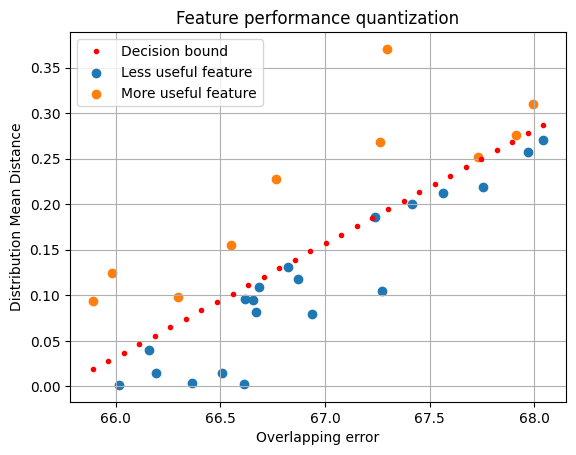

In [11]:
x_axis = np.linspace(np.min(ovr_error), np.max(ovr_error), len(ovr_error))
trending_line = lambda x: 0.1246 * x - 8.1913
bounded_feature = trending_line(np.array(ovr_error))
total_features = 0
for i, e in enumerate(bounded_feature):
    if e - mean_diffs[i] > 0:
        bounded_feature[i] = 1
    else:
        total_features += 1
        bounded_feature[i] = 0



fig, ax = plt.subplots()
ax.plot(x_axis, trending_line(x_axis),'.r', linewidth=2)
ax.scatter(np.array(ovr_error)[bounded_feature==1], np.array(mean_diffs)[bounded_feature==1])
ax.scatter(np.array(ovr_error)[bounded_feature==0], np.array(mean_diffs)[bounded_feature==0])
ax.legend(['Decision bound', 'Less useful feature', 'More useful feature'], loc='best')
ax.set_xlabel('Overlapping error')
ax.set_ylabel('Distribution Mean Distance')
ax.set_title('Feature performance quantization')
ax.grid(True)
mlflow.log_figure(fig, 'mlflow/figures/Feature_performance_quantization.png')



Descartamos las features que se encuentran por debajo de la linea de tendencia, de manera que contaremos con 10/30 dimensiones en nuestro dataset.
Utilizando la información obtenida de las distribuciones, podemos utilizar dichos espacios para realizar un Data Augmentation generando muestras artificiales en función de la distribución correspondiente.
De esta manera, conseguimos un dataset limpio de outliers, con las features más útiles(presúntamente) y con clases balanceadas.

In [12]:
_ = []
for i, bf in enumerate(bounded_feature):
    if bf == 0:
        _.append(X[:,i])
_ = np.array(_).swapaxes(0,1)
X = _
#Data augmentation to solve unbalanced classes
X, y = data_augmentation(X, y)

mlflow.end_run()

END DATA ENGINEERING

In [13]:
X, y = shuffle(X, y)
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.25)

LINEAR CLASSIFIER

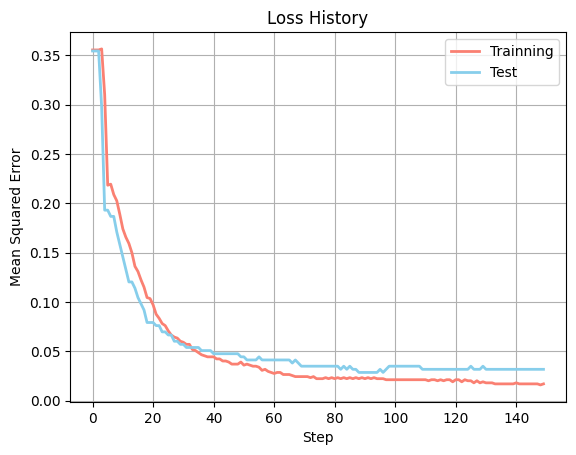

In [14]:
mlflow.start_run(run_name='linear_classifier')
lc = LinearClassifier(X.shape[1])
loss_train = []
loss_test = []
steps = 150
lr = 0.001
mlflow.pyfunc.log_model(
    python_model=lc,
    artifact_path="mlflow/models/linear_classifier",
    input_example=X_test,
    registered_model_name="linear_classifier"
)

mlflow.log_param('steps', steps)
mlflow.log_param('lr', lr)

for i in range(steps):
    display.clear_output(wait=True)
    y_hat = lc.predict(X_train)
    lc.update_weights(y_train, y_hat, X_train, lr = lr)
    loss = np.mean(lc.loss[0](y_train, y_hat))
    loss_train.append(loss)
    mlflow.log_metric('loss_train', loss, i)
    
    y_hat = lc.predict(X_test)
    loss = np.mean(lc.loss[0](y_test, y_hat)) 
    loss_test.append(loss)
    mlflow.log_metric('loss_test', loss, i)

    plt.plot(loss_train, color='salmon', linewidth=2, label= 'Trainning')
    plt.plot(loss_test, color='skyblue', linewidth=2,label= 'Test')
    
    plt.grid(True)
    plt.legend(loc='best')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Step')
    plt.title('Loss History')
    plt.show()
    
y_hat = lc.predict(X_test)
score = metrics(y_test, y_hat)
mlflow.log_dict(score, 'mlflow/scores/linear_classifier.json')
score
mlflow.end_run()



LOGISTIC CLASSIFIER

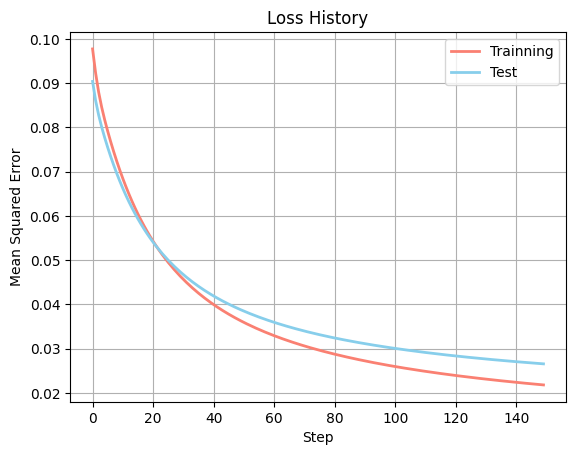

In [15]:
mlflow.start_run(run_name='logistic_classifier')
logc = LogisticClassifier(X.shape[1])
loss_train = []
loss_test = []
steps = 150
lr = 0.01
mlflow.pyfunc.log_model(
    python_model=logc,
    artifact_path="mlflow/models/logistic_classifier",
    input_example=X_test,
    registered_model_name="logistic_classifier"
)

mlflow.log_param('steps', steps)
mlflow.log_param('lr', lr)

for i in range(steps):
    display.clear_output(wait=True)
    y_hat, z = logc.predict(X_train, trainning=True)
    logc.update_weights(y_train, y_hat, z, X_train, lr = lr)
    loss = np.mean(logc.loss[0](y_train, y_hat))
    loss_train.append(loss)
    mlflow.log_metric('loss_train', loss, i)


    y_hat, z = logc.predict(X_test, trainning=True)
    loss = np.mean(logc.loss[0](y_test, y_hat))
    loss_test.append(loss)
    mlflow.log_metric('loss_test', loss, i)


    plt.plot(loss_train, color='salmon', linewidth=2, label= 'Trainning')
    plt.plot(loss_test, color='skyblue', linewidth=2, label= 'Test')
    plt.grid(True)
    plt.legend(loc='best')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Step')
    plt.title('Loss History')
    plt.show()

y_hat = logc.predict(X_test)
score = metrics(y_test, y_hat)
mlflow.log_dict(score, 'mlflow/scores/logistic_classifier.json')
score
mlflow.end_run()

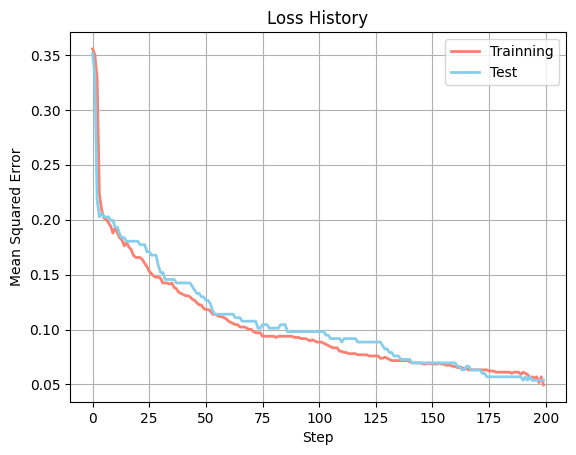

In [16]:
mlflow.start_run(run_name='multilayer_perceptron')
topology = [15, 1]
mlp = MLP(topology, X_train.shape[1])
loss_train = []
loss_test = []
steps = 200
lr = 0.001
mlflow.pyfunc.log_model(
    python_model=mlp,
    artifact_path="mlflow/models/multilayer_perceptron",
    input_example=X_test,
    registered_model_name="multilayer_perceptron"
)

mlflow.log_param('steps', steps)
mlflow.log_param('lr', lr)

for i in range(steps):
    
    display.clear_output(wait=True)
    y_hat = mlp.predict(X_train)
    mlp.update_weights(y_train, lr = lr)
    loss = np.mean(mlp.loss[0](y_train, y_hat))
    loss_train.append(loss)
    mlflow.log_metric('loss_train', loss, i)

    y_hat = mlp.predict(X_test)
    loss = np.mean(mlp.loss[0](y_test, y_hat))
    loss_test.append(loss)
    mlflow.log_metric('loss_test', loss, i)

    plt.plot(loss_train, color='salmon', linewidth=2, label= 'Trainning')
    plt.plot(loss_test, color='skyblue', linewidth=2, label= 'Test')
    plt.grid(True)
    plt.legend(loc='best')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Step')
    plt.title('Loss History')
    plt.show()

y_hat = mlp.predict(X_test)
score = metrics(y_test, y_hat)
mlflow.log_dict(score, 'mlflow/scores/multilayer_perceptron.json')
score
mlflow.end_run()

In [24]:
mlflow.start_run(run_name='mixture_models')
mm = MixtureModels()

mlflow.pyfunc.log_model(
    python_model=mm,
    artifact_path="mlflow/models/mixture_models",
    input_example=X_test,
    registered_model_name="mixture_models"
)
mm.learn_params(X_train, y_train)
# mlflow.log_dict(mm.params, 'mlflow/models/mixture_models/parameters')
# semisupervised_forecasts, semisupervised_posterior, semisupervised_loglikelihoods = mm.run_em(X_train)
mm.run_em(X_train)
y_hat = mm.predict(X_test)

score = metrics(y_test, y_hat)
mlflow.log_dict(score, 'mlflow/scores/mixture_models.json')
score
mlflow.end_run()

Registered model 'mixture_models' already exists. Creating a new version of this model...
2023/04/30 17:53:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mixture_models, version 4
Created version '4' of model 'mixture_models'.


In [23]:
mlflow.start_run(run_name='decision_tree')
dt = DecisionTree()
mlflow.pyfunc.log_model(
    python_model=dt,
    artifact_path="mlflow/models/decision_tree",
    input_example=X_test,
    registered_model_name="decision_tree"
)

dt.fit(X_train, y_train)
y_hat = dt.predict(X_test)
score = metrics(y_test, y_hat)
mlflow.log_dict(score, 'mlflow/scores/decision_tree.json')
score
mlflow.end_run()

Successfully registered model 'decision_tree'.
2023/04/30 17:53:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: decision_tree, version 1
Created version '1' of model 'decision_tree'.
